# Setting the Baseline
Initiating the baseline functions, classes and models.

Importing the necessary keys

In [1]:
# Creating the environment for the notebook and importing the necessary keys

from dotenv import load_dotenv
import os
load_dotenv()

OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')
ASTRA_DB_API_KEY = os.getenv('ASTRA_DB_API_KEY')
ASTRA_DB_ENDPOINT = os.getenv('ASTRA_DB_ENDPOINT')
ASTRA_DB_KEYSPACE = os.getenv('ASTRA_DB_KEYSPACE')

# Making a function for loading the model and importing the openai classes

from langchain_openai.embeddings import OpenAIEmbeddings
from langchain_openai import ChatOpenAI

def load_model(model_name: str = "gpt-4o", tools=None):
    """Load the model dynamically based on the parameter."""
    model = ChatOpenAI(
        model=model_name,
        temperature=0,
    )
    # Bind tools if provided
    if tools:
        model = model.bind_tools(tools)
    
    return model

embeddings = OpenAIEmbeddings()

from langchain_community.vectorstores import AstraDB

# Making a function to get the vectorstore for later use

def get_vectorstore(collection_name: str) -> AstraDB:
    return AstraDB(
    embedding=embeddings,
    token=ASTRA_DB_API_KEY,
    api_endpoint=ASTRA_DB_ENDPOINT,
    collection_name=collection_name,
    )

from pydantic import BaseModel, Field

# Creating an baseline modelresponse that can be inheritated by other classes later

class ResponseModel(BaseModel):
    agent_name: str

In [2]:
from langchain.chains.query_constructor.schema import AttributeInfo
from langchain.retrievers.self_query.base import SelfQueryRetriever

metadata_field_info = [
    AttributeInfo(
        name='header',
        description="The 'header' of the page. The 'header' is one of ['Overview', 'Tasks', 'Setup', 'Additional information']",
        type="string",
    ),
]

document_content_description = "The pages"

In [3]:
def metadata_retriever_tool(query: str, rag_collection: str = "not_metadata") -> str:
    """Retrieve documents based on a user query and return context."""
    vectorstore = get_vectorstore(rag_collection)
    model = load_model()
    retriever = SelfQueryRetriever.from_llm(
    model, 
    vectorstore, 
    document_content_description, 
    metadata_field_info, 
    verbose=True,
    search_kwargs={"k": 10},
    # other search kwargs:  {"score_threshold": 0.5}z
    )
    retrieved_documents = retriever.invoke(query)
    context = "<br />".join([doc.page_content for doc in retrieved_documents])
    return context

In [4]:
from langchain_core.prompts import ChatPromptTemplate

system_instructions = """
You are an expert at analyzing pdf documents.
You are going to analyze a pdf document and retrieve the content
"""

query_data = """
Here is the pdf document content you want to analyze:
{pdf_document}
"""

prompt = ChatPromptTemplate.from_messages([
    ("system", system_instructions),
    ("human", query_data),
])

In [5]:
new = prompt.invoke(input={"pdf_document":system_instructions})
new

ChatPromptValue(messages=[SystemMessage(content='\nYou are an expert at analyzing pdf documents.\nYou are going to analyze a pdf document and retrieve the content\n', additional_kwargs={}, response_metadata={}), HumanMessage(content='\nHere is the pdf document content you want to analyze:\n\nYou are an expert at analyzing pdf documents.\nYou are going to analyze a pdf document and retrieve the content\n\n', additional_kwargs={}, response_metadata={})])

## The standard create agent

In [6]:
from typing import Callable, List
from langgraph.prebuilt import tools_condition, ToolNode
from langchain_core.messages import SystemMessage, AIMessage, HumanMessage
from langgraph.prebuilt import ToolNode


def create_agent(prompt: str, tools: List[Callable], parser: BaseModel = None, call_after_tool: bool = True):
    
    def agent(state, config):
        llm = load_model(model_name=state.llm_model_name, tools=tools)
        
        if parser:
            llm = llm.with_structured_output(schema=parser)
        

        prompt = prompt.invoke(input={"pdf_document": "pdf_document"})

        try:
            response = llm.invoke(prompt)
            state.messages.append(response)

            # If tool calls detected, invoke the tools
            if tools_condition(state) == 'tools':
                tool_node = ToolNode(tools)
                response = tool_node.invoke(state)
                #print("tool node response: ", response)
                for tool_message in response['messages']:
                    state.messages.append(tool_message)
                    if tool_message.artifact:
                        # Update state with artifacts
                        state = state.copy(update=tool_message.artifact)
                    
                if call_after_tool:
                    agent(state, config)
                else:
                    return state
                
        except Exception as e:
            state.error_message = f"An error occurred while generating variables: {e}"
            return state
        
        return state

    return agent

## PDF loader

source for choosing of loader:

https://towardsdatascience.com/analyzing-unstructured-pdf-data-w-embedding-models-and-llms-f83ae9a57c2b/

Run the pip install first

In [7]:
#pip install fitz frontend pymupdf

# Graph

1. The user gives a list of structured requirements that the test should contain 
2. A retriever agent that finds the correct pdf(s) based on the requirements from the user
2. A analyzing agent retrieves all the content from each page
3. Make a new test based on the requirements and the retrieved pdf(s)

## Defining the state

1. We need to import all the essentials for running the graph
2. Then we define the properties of the system

In [8]:
from langgraph.graph import StateGraph, START, END
from langgraph.types import Send
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import display, Image
from langchain_core.documents import Document
from typing import Annotated, List
from pydantic import BaseModel, Field
import operator
import uuid


GET_PDF_FILES = "get_pdf_files"
GET_PDF_CONTENT = "get_pdf_content"


class PDF_Image(BaseModel):
    id: uuid.UUID
    content: str
    page_number: int

class PDF(BaseModel):
    id: uuid.UUID
    documents: Annotated[List[Document], operator.add] = Field(default_factory=list)
    images: Annotated[List[PDF_Image], operator.add] = Field(default_factory=list)

class InputState(BaseModel):
    requirements: List[str]
    data_path: str

class AgentState(BaseModel):
    next_agent: str = GET_PDF_FILES
    llm_model_name: str = "gpt-4o-mini"
    pdfs: Annotated[List[PDF], operator.add] = Field(default_factory=list)
    error_message: Annotated[str, operator.add] = ""
    data_path: str = "../../data"
    files: List[str] = Field(default_factory=list)
    chosen_files: List[str] = Field(default_factory=list)
    requirements: List[str] = Field(default_factory=list)

## Creating the retrieiver for the pdf files

In [9]:
import os

files = []

def get_pdf_files(state: AgentState):
    # Load the global files
    global files
    files = []
    try:
        data_path = state.data_path
        #  Get the files in the data directory
        for file in os.listdir(data_path):
            if file.endswith(".pdf"):
                files.append(file)
    except Exception as e:
        state.error_message = f"An error occurred while retrieving the files: {e}"
        return state
    
    state.files = files
    return state

## Creating the agent for retriving the correct pdf

In [10]:
################# Our custom retriever prompt ######################

from langchain_core.prompts import ChatPromptTemplate

system_instructions = """
You are an expert at retriving the correct pdfs based on some requirements from the user.
Analyze the requirements and retrieve the correct pdfs and find the correct pdf.
There are following pdfs you can retrieve content from:
examples:
    user: Here is my requirements: ['requirement1', 'requirement2']
    ai-agent: [file.pdf, file2.pdf]

    user: Here is my requirements: ['requirement1', 'requirement2', 'requirement3']
    ai-agent: [file.pdf]
"""

query_data = """
Here are the pdf files you can retrieve:
{files}

Which files do you want to retrieve content from given theese requirements: 
{requirements}
"""

retrieve_prompt = ChatPromptTemplate.from_messages([
    ("system", system_instructions),
    ("human", query_data),
])

################# Our custom function for retriving pdf content ######################

import fitz

def get_pdf_content(pdf_path: str) -> dict:
    pdf_document = fitz.open(pdf_path)
    text = []
    for page_num in range(len(pdf_document)):
        page = pdf_document.load_page(page_num)
        text.append(page.get_text())
    return text


################# Our custom agent ######################

class RetrieverOutput(BaseModel):
    pdf_files: List[str]

RETRIEVER_AGENT = "retriever_agent"

def create_retrieve_agent(chat_prompt: str, agent_name: str, parser: BaseModel = None):
    
    def agent(state):
        llm = load_model(model_name=state.llm_model_name)
        # Makes the prompt template with the values from the state
        prompt = chat_prompt.invoke(input={
            "files": state.files,
            "requirements": state.requirements
            })

        llm_with_structured_output = llm.with_structured_output(schema=parser)
        try:
            response = llm_with_structured_output.invoke(prompt)
            print(f"Response: {response}")
            #response.agent_name = agent_name
            chosen_files = response.pdf_files
            state.chosen_files = chosen_files

            if len(chosen_files) == 0:
                state.error_message = "No files were chosen."
                state.next_agent = END
            else:
                state.next_agent = GET_PDF_CONTENT
            
        except Exception as e:
            state.error_message = f"An error occurred while generating variables: {e}"
            return state
        return state

    return agent

retriever_agent = create_retrieve_agent(
    chat_prompt=retrieve_prompt,
    parser=RetrieverOutput,
    agent_name=RETRIEVER_AGENT
)

In [ ]:
import base64
import io
import fitz
from PIL import Image as PILImage

def pdf_page_to_base64(pdf_path: str, page_number: int) -> str:
    pdf_document = fitz.open(pdf_path)
    page = pdf_document.load_page(page_number - 1)  # input is one-indexed
    pix = page.get_pixmap()
    img = PILImage.frombytes("RGB", [pix.width, pix.height], pix.samples)

    buffer = io.BytesIO()
    img.save(buffer, format="PNG")

    return base64.b64encode(buffer.getvalue()).decode("utf-8")

def get_pdf_content(pdf_path: str) -> List[Document]:
    pdf_document = fitz.open(pdf_path)
    documents = []
    for page_num in range(len(pdf_document)):
        page = pdf_document.load_page(page_num)
        page_content = page.get_text()
        document = Document(
            page_content=page_content,
            metadata={"source": pdf_path, "page_number": page_num + 1}
        )
        documents.append(document)
    return documents


GET_TEXT_CONTENT = "get_text_content"

def get_text_content(state: AgentState) -> AgentState:
    pdf_path = state.data_path
    files = state.chosen_files
    for file in files:
        pdf_content = get_pdf_content(f"{pdf_path}/{file}")
        pdf = PDF(id=uuid.uuid4(), documents=pdf_content)
        state.pdfs.append(pdf)
    print("Saved the follwing text from pdfs: ", state.pdfs)
    return state


GET_IMAGE_CONTENT = "get_image_content"

class ImageInformation(BaseModel):
    """Information about an image."""
    content: str


system_instructions = """
Analyze the image content of page {page_num}
"""

query_data = """
{base64_image}
"""

prompt = ChatPromptTemplate.from_messages([
    ("system", system_instructions),
    ("human", query_data),
])


def get_image_content_agent(prompt: str, parser: BaseModel = None):
    
    def agent(state):
        llm = load_model(model_name=state.llm_model_name)
        pdf_path = state.data_path
        files = state.chosen_files
        pdfs = state.pdfs
        structured_image_agent = llm.with_structured_output(schema=parser)
        try:
            # Loop through the files
            for file, pdf in zip(files, pdfs):
                for document in pdf.documents:
                    page_num = document.metadata["page_number"]
                    base64_image = pdf_page_to_base64(f"{pdf_path}/{file}", page_num)
                    print(f"Infering the image content of page {page_num}")
                        # Define the query
                    query = f"Analyze the content of the image in {page_num}"

                    # Create the message with text and image
                    message = HumanMessage(
                        content=[
                            {"type": "text", "text": query},
                            {
                                "type": "image_url",
                                "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"},
                            },
                        ],
                    )

                    # Query the model
                    response = llm.invoke([message])
                    pdf.images.append(PDF_Image(id=uuid.uuid4(), content=response.content, page_number=page_num))
            state.pdfs = pdfs
        except Exception as e:
            state.error_message = f"An error occurred while generating variables: {e}"
        return state

    return agent

image_content_agent = get_image_content_agent(prompt=prompt, parser=ImageInformation)

In [12]:
builder = StateGraph(state_schema=AgentState, input=InputState)

builder.add_node(GET_PDF_FILES, get_pdf_files)
builder.add_node(RETRIEVER_AGENT, retriever_agent)
builder.add_node(GET_TEXT_CONTENT, get_text_content)
builder.add_node(GET_IMAGE_CONTENT, image_content_agent)

builder.add_edge(START, GET_PDF_FILES)
builder.add_edge(GET_PDF_FILES, RETRIEVER_AGENT)
builder.add_edge(RETRIEVER_AGENT, GET_TEXT_CONTENT)
builder.add_edge(GET_TEXT_CONTENT, GET_IMAGE_CONTENT)
builder.add_edge(GET_IMAGE_CONTENT, END)


memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

print(graph.get_graph().draw_mermaid())

%%{init: {'flowchart': {'curve': 'linear'}}}%%
graph TD;
	__start__([<p>__start__</p>]):::first
	get_pdf_files(get_pdf_files)
	retriever_agent(retriever_agent)
	get_text_content(get_text_content)
	get_image_content(get_image_content)
	__end__([<p>__end__</p>]):::last
	__start__ --> get_pdf_files;
	get_image_content --> __end__;
	get_pdf_files --> retriever_agent;
	get_text_content --> get_image_content;
	retriever_agent --> get_text_content;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



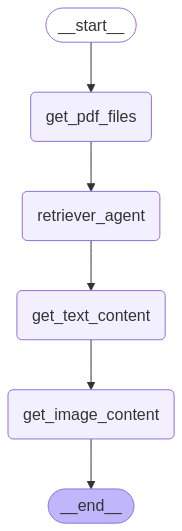

In [13]:
display(Image(graph.get_graph().draw_mermaid_png()))

## Running the graph

In [14]:
config = {
    "configurable": {
        "thread_id": str(uuid.uuid4()),
        }}


def run_client(requirements: list[str], config: dict[str, dict[str, str]] = config) -> AgentState:
    print("### Start Client ###\n")

    state = InputState(
    requirements=requirements,
    data_path="../../data",

    )

    output_state = graph.invoke(state, config)

    if error := output_state.get("error_message"):
        print("\n🙈", error)

    return output_state


In [ ]:
query = "I want to retrieve the test without images?"
#query=""

requirements = [query] 

run_client(requirements=requirements)

### Start Client ###

Response: pdf_files=['test_with_images.pdf']
Saved the follwing text from pdfs:  [PDF(id=UUID('3db1cf5b-306b-46f6-964b-2aa933bb3cb3'), documents=[Document(metadata={'source': '../../data/test_with_images.pdf', 'page_number': 1}, page_content='DISXRA Rental Agreement to Invoice.docx \n \nPage  1 \n \nRental Agreement to Invoice \nRental is a supplementary revenue stream for distribution companies. Customers can be professionals with an \nexisting customer number, or they can be walk-in customers. A daily rate will be charged for the number of days \nthe items were at the customer’s site. The agreements tend to have a short validity period, often only a few days. \nA rental agreement is a combination of two distribution orders: \n \n \n \nCustomers can either pay directly (cash) via the cash desk, or they can pay against a rental invoice (credit). Two \nrental agreement order types are defined for that purpose: \n• \nCO1 – Cash via the cash desk: immediate payment o

{'next_agent': 'get_pdf_content',
 'pdfs': [PDF(id=UUID('3db1cf5b-306b-46f6-964b-2aa933bb3cb3'), documents=[Document(metadata={'source': '../../data/test_with_images.pdf', 'page_number': 1}, page_content='DISXRA Rental Agreement to Invoice.docx \n \nPage  1 \n \nRental Agreement to Invoice \nRental is a supplementary revenue stream for distribution companies. Customers can be professionals with an \nexisting customer number, or they can be walk-in customers. A daily rate will be charged for the number of days \nthe items were at the customer’s site. The agreements tend to have a short validity period, often only a few days. \nA rental agreement is a combination of two distribution orders: \n \n \n \nCustomers can either pay directly (cash) via the cash desk, or they can pay against a rental invoice (credit). Two \nrental agreement order types are defined for that purpose: \n• \nCO1 – Cash via the cash desk: immediate payment of the rental deposit or the entire rental invoice as an \nad

In [20]:
state_values = graph.get_state(config=config).values
pdfs = state_values["pdfs"]

image_content = []
for image in pdfs[0].images:
    image_content.append(image.content)

image_content

['The content of page 1 outlines a rental agreement process for distribution companies, detailing how customers can rent items and the associated financial transactions. Here are the key points:\n\n1. **Rental Overview**:\n   - Rental serves as an additional revenue stream.\n   - Customers can be existing clients or walk-ins.\n   - Daily rates apply based on the rental duration.\n\n2. **Types of Rental Orders**:\n   - **Outbound Distribution**: When the rental agreement is activated, items are checked out.\n   - **Inbound Distribution**: When the rental agreement is terminated, items are checked in.\n\n3. **Payment Methods**:\n   - Customers can pay directly at the cash desk or via a rental invoice.\n   - Two order types are defined:\n     - **CO1**: Cash payment at the cash desk for immediate invoicing.\n     - **CO2**: Credit against an invoice with standard payment terms.\n\n4. **Deposits**:\n   - Customers are encouraged to provide a deposit, which is reconciled upon return of the 